In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

from scipy.stats import pointbiserialr, kruskal, ttest_ind, f_oneway, shapiro, mannwhitneyu, levene
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

In [3]:
fImpReal = pickle.load(open('fImpReal.fn', 'rb'))
getTransactions = pickle.load(open('getTransactions.fn', 'rb'))
groupDF = pickle.load(open('groupDF.sav', 'rb'))

In [3]:
train = pd.read_csv('Data/Train.csv', index_col=[0])
trans_date = train['transaction_val_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train['transaction_val_dt'] = trans_date

test = pd.read_csv('Data/Test_fin.csv', index_col=0)
trans_date = test['transaction_val_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['transaction_val_dt'] = trans_date

### Homogenity

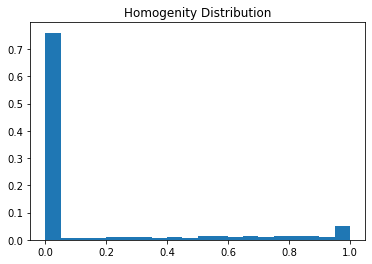

Number of homogenous solution companies: 2628


In [4]:
train['dd'] = train.apply(lambda x: x['transaction_val_dt'].day, axis=1)

comp_gps = train.groupby('rem_company_id_dummy')
payroll_avg = comp_gps['payroll_ind'].mean()
weights = np.ones_like(payroll_avg) / len(payroll_avg)
plt.hist(payroll_avg, bins=20, weights=weights)
plt.title('Homogenity Distribution')
plt.show()

homo_comps = sum((comp_gps['payroll_ind'].mean()==1) | (comp_gps['payroll_ind'].mean()==0))
print('Number of homogenous solution companies:', homo_comps)

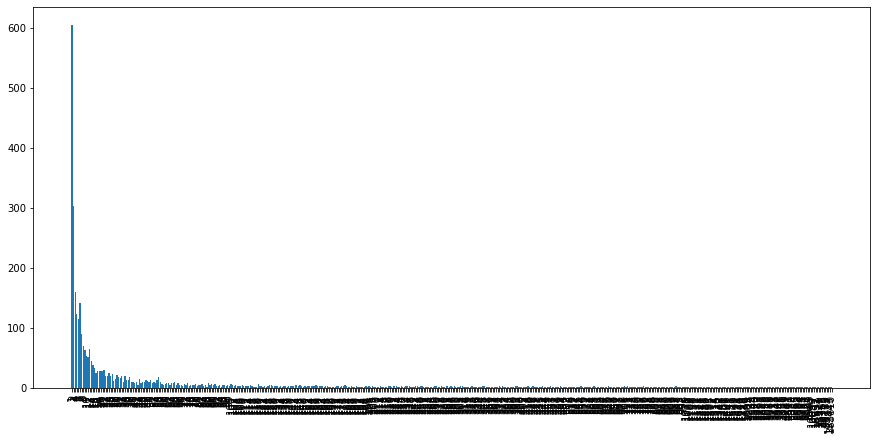

In [33]:
loc, freq = np.unique(comp_gps.count()['payroll_ind'], return_counts=True)
plt.figure(figsize=(15, 7))
plt.bar(range(len(loc)), freq)
plt.xticks(range(len(loc)), loc, rotation=90)
plt.show()

In [5]:
comp_names = list(comp_gps.groups.keys())

In [6]:
def fn(x):
    n_inds = len(np.unique(x))
    if n_inds == 1 or 'Unknown' not in x:
        return n_inds
    else:
        return n_inds-1
    
n_ind = comp_gps['rem_company_ind'].unique().apply(fn)

In [7]:
multi_ind = comp_gps['rem_company_ind'].unique().apply(fn)
inds = list(multi_ind[multi_ind>1].index)
print('Transactions of companies with more than 1 industry', len(train[train['rem_company_id_dummy'].isin(inds)]))

Transactions of companies with more than 1 industry 1615


In [8]:
def get_n_ind(x):
    global multi_ind
    comp = x['rem_company_id_dummy']
    return multi_ind[comp]

groupDF['comp_n_ind'] = groupDF.apply(get_n_ind, axis=1)

In [9]:
comp_dd_means = comp_gps['dd'].mean()
comp_dd_vars = comp_gps['dd'].var(ddof=0)

def get_dd_props(x):
    global comp_dd_means, comp_dd_vars
    comp = x['rem_company_id_dummy']
    return abs(comp_dd_means[comp]-x['dd_mean']), x['dd_var']/comp_dd_vars[comp]

dd_props = groupDF.apply(get_dd_props, axis=1)
groupDF['dd_diff_comp'], groupDF['dd_var_ratio_comp'] = dd_props.str

In [10]:
comp_txn_means = comp_gps['txn_amt'].mean()
comp_txn_vars = comp_gps['txn_amt'].var(ddof=0)

def get_txn_props(x):
    global comp_txn_means, comp_txn_vars
    comp = x['rem_company_id_dummy']
    return comp_txn_means[comp]-x['txn_amt_mean'], x['txn_amt_var']/comp_txn_vars[comp]

txn_props = groupDF.apply(get_txn_props, axis=1)
groupDF['txn_amt_diff_comp'], groupDF['txn_amt_var_ratio_comp'] = txn_props.str

In [11]:
def getAvgTxnPerDay(x):
    return len(x)/x['transaction_val_dt'].nunique()

avgTxnPerDay = comp_gps.apply(getAvgTxnPerDay)

def get_txn_per_day_ratio(x):
    global avgTxnPerDay
    comp = x['rem_company_id_dummy']
    return x['avgTxnPerDay']/avgTxnPerDay[comp]

txn_per_day_ratio = groupDF.apply(get_txn_per_day_ratio, axis=1)
groupDF['txnPerDay_ratio_comp'] = txn_per_day_ratio

In [12]:
def getGapVar(x):
    if len(x)>1:
        return x['transaction_val_dt'].sort_values().diff()[1:].apply(lambda x: x.days).var(ddof=0)
    else:
        return 0
    
delta = (comp_gps['transaction_val_dt'].max()-comp_gps['transaction_val_dt'].min()).apply(lambda x: x.days)
avgTxnGap = delta/(comp_gps.count()['payroll_ind']-1)
varTxnGap = comp_gps.apply(getGapVar)

In [13]:
def get_txn_gaps(x):
    global avgTxnGap, varTxnGap
    comp = x['rem_company_id_dummy']
    return avgTxnGap[comp]-x['avg_txn_time'], x['varTxnGap']/varTxnGap[comp]

txn_gap_info = groupDF.apply(get_txn_gaps, axis=1)
groupDF['txnGap_diff_comp'], groupDF['txnGap_var_ratio_comp'] = txn_gap_info.str

In [14]:
groupDF

,n_txn,payroll_ind,rem_company_id_dummy,txn_amt_var,txn_amt_mean,txn_rate,avg_txn_time,varTxnGap,avgTxnPerDay,dd_mean,dd_var,comp_n_ind,dd_diff_comp,dd_var_ratio_comp,txn_amt_diff_comp,txn_amt_var_ratio_comp,txnPerDay_ratio_comp,txnGap_diff_comp,txnGap_var_ratio_comp
"(5000000, 8000000)",3,0,1000000000,0.000954,1.480575,0.025641,58.500000,90.250000,1.0,11.333333,24.222222,1,4.986326,0.418322,3.380077,0.000001,0.090557,-58.362122,329.636961
"(5000000, 8538500)",4,0,1000000000,0.038843,1.337178,0.250000,5.333333,11.555556,1.0,11.000000,38.000000,1,5.319659,0.656267,3.523474,0.000055,0.090557,-5.195456,42.206518
"(5000000, 8813800)",3,0,1000000000,0.465905,1.553873,0.081081,18.500000,72.250000,1.0,15.666667,16.888889,1,0.652993,0.291674,3.306778,0.000660,0.090557,-18.362122,263.892193
"(5000000, 9768200)",7,0,1000000000,0.003921,1.081052,0.041667,28.000000,73.000000,1.0,21.285714,47.346939,1,4.966055,0.817691,3.779600,0.000006,0.090557,-27.862122,266.631559
"(5000000, 9784300)",2,0,1000000000,0.000000,1.218439,0.181818,11.000000,0.000000,1.0,9.500000,30.250000,1,6.819659,0.522423,3.642212,0.000000,0.090557,-10.862122,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(5742900, 74564200)",1,0,1000005090,0.000000,3.572418,0.079598,35.559001,0.000000,1.0,26.000000,0.000000,1,7.663522,0.000000,0.573142,0.000000,0.073585,-35.446980,0.000000
"(5743300, 74530200)",1,0,1000038290,0.000000,1.054750,0.079598,35.559001,0.000000,1.0,26.000000,0.000000,1,0.000000,NaN,0.000000,NaN,1.000000,NaN,NaN
"(5743500, 74532600)",1,0,1000024130,0.000000,7.023683,0.079598,35.559001,0.000000,1.0,26.000000,0.000000,1,0.909091,0.000000,-4.924309,0.000000,0.242424,-30.840251,0.000000
"(5743600, 74560500)",1,0,1000038310,0.000000,5.312126,0.079598,35.559001,0.000000,1.0,26.000000,0.000000,1,0.000000,NaN,0.000000,NaN,1.000000,NaN,NaN


In [15]:
pickle.dump(groupDF, open('groupDF.sav', 'wb'))

In [16]:
groupDF.to_csv('groupDF.csv')